# Memory tasks for LLMs
Authors: Chris Iyer, Sam Lippl

combining all tasks into one notebook for smoother model usage

In [328]:
import sys, random
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import pipeline

# for running on colab
if 'google.colab' in sys.modules:
    !git clone https://github.com/sflippl/models-of-memory.git
    sys.path.append('models-of-memory')
    dir = 'models-of-memory'
else:
    print("Running locally")
    dir = '.'

fatal: destination path 'models-of-memory' already exists and is not an empty directory.


# Shared helper functions

In [329]:
def txt_to_list(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip().lower() for line in f.readlines()]
    return lines


def subsample_words(words, n, seed=None, avoid=[]):
    """
    Return a random subset of n unique words from the list.
    Optionally set a random seed for reproducibility.
    """
    if n > len(words):
        raise ValueError("Sample size cannot exceed number of words.")
    if seed is not None:
        random.seed(seed)
    if len(avoid) > 0:
        words = [w for w in words if w not in avoid]
    return random.sample(words, n)


def make_pairs(first_words, second_words, joiner='-', randomize=False):
    # "chair-apple"
    np.random.seed(0)
    rand_draws = np.random.rand(len(first_words))
    pairs = []
    for first, second, rand in zip(first_words, second_words, rand_draws):
        if randomize and rand < 0.5:
            first, second = second, first
        pairs.append(f'{first}{joiner}{second}')
    return pairs


def make_test_probes(cue_words, target_words, lure_words):
    # for paired associate tests: 2-alternative-forced-choice tests
    np.random.seed(0)
    perm = np.random.permutation(len(cue_words))
    cue_words = np.array(cue_words)[perm]
    target_words = np.array(target_words)[perm]
    lure_words = np.array(lure_words)[perm]
    out = []
    rand_draw = np.random.rand(len(cue_words))
    for i,(c,t,l) in enumerate(zip(cue_words, target_words, lure_words)):
        if rand_draw[i] < 0.5:
            out.append(f'{c}: {t} or {l}?')
        else:
            out.append(f'{c}: {l} or {t}?')
    return out, list(target_words), list(lure_words)


def make_training_order(first_pairs, second_pairs, unrelated_pairs=[]):
    # for paired associate inference nad acquired equivalence
    # AB[i] must come before BC[i], but DE can come anywhere
    all_items = first_pairs + second_pairs + unrelated_pairs
    random.seed(0)
    random.shuffle(all_items)
    # now loop through random list and replace any BC that are before their AB pair
    for i, (first, second) in enumerate(zip(first_pairs, second_pairs)):
        first_idx = all_items.index(first)
        second_idx = all_items.index(second)
        if second_idx < first_idx:
            # remove second and reinsert it after first at a random later position
            all_items.pop(second_idx)
            first_idx = all_items.index(first)
            insert_pos = random.randint(first_idx + 1, len(all_items))
            all_items.insert(insert_pos, second)
    return all_items


def is_derangement(original_list, permuted_list):
    """Checks if a permuted list is a derangement of the original list."""
    for i in range(len(original_list)):
        if original_list[i] == permuted_list[i]:
            return False
    return True

def generate_derangement(input_list):
    """Generates a random derangement (permutation but all entries are changed) of the input list."""
    random.seed(0)
    temp_list = list(input_list) # Create a copy to avoid modifying the original
    while True:
        random.shuffle(temp_list)
        if is_derangement(input_list, temp_list):
            return temp_list


In [330]:
def make_inp(words, test_words=[], preamble='', cue='', interjection=None, interjection_words=[]):
    inp = f'{preamble} {", ".join(words)}. '
    if interjection:
        inp += f'{interjection} {", ".join(interjection_words)}. '
    inp += cue
    if len(test_words) > 0:
        inp += ", ".join(test_words)
    return inp


def make_pipe(model_id):
    pipe = pipeline(
        "text-generation",
        model=model_id,
        dtype=torch.bfloat16,
        device_map="auto",
    )
    return pipe


def query_model_helper(pipe, inp):
    messages = [
    {"role": "user", "content": inp},
    ]
    outputs = pipe(
        messages,
        max_new_tokens=256,
        temperature=0.7,
        top_p=0.8,
        top_k=20,
        min_p=0.

    )
    return outputs

def query_model(pipe, inp):
    outputs = query_model_helper(pipe, inp)
    lst_words = outputs[0]["generated_text"][-1]['content'].split('— Wait')[0].split(', ')
    lst_words = [w.strip().lower() for w in lst_words]
    return lst_words

# Load


In [331]:
all_words = txt_to_list(f'{dir}/_data/wasnorm_wordpool.txt')

In [332]:
pipe = make_pipe(model_id = "Qwen/Qwen3-4B-Instruct-2507")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


# 1. List learning

In [149]:
list_length = 50
interjection_length = 200

In [150]:
def plot_recall_precision(true_list, output_list, interjected_list=[], gated=False):
    if gated:
      subset_of_words = [w for w in true_list if w[0] in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
    else:
      subset_of_words = true_list
    recall = [w in output_list for w in subset_of_words]
    precision = [w in set(subset_of_words) for w in np.unique(output_list)]
    ncols = 2
    i_bool = len(interjected_list) >0
    if i_bool:
        precision_int = [w in set(interjected_list) for w in np.unique(output_list)]
        ncols = 3

    fig,ax = plt.subplots(1,ncols, figsize=(6,3))
    ax[0].plot(recall)
    ax[0].set_title('Recall')
    ax[0].set_xlabel('Word in true list')
    ax[0].set_ylabel('Present in recalled list')

    ax[1].plot(precision)
    ax[1].set_title('Precision')
    ax[1].set_xlabel('Word in output (unique)')
    ax[1].set_ylabel('Present in true list')

    if i_bool:
        ax[2].plot(precision_int)
        ax[2].set_title('False alarms to interjections')
        ax[2].set_xlabel('Word in output (unique)')
        ax[2].set_ylabel('Present in interjection')
    plt.tight_layout()
    plt.show()

In [8]:
words = subsample_words(all_words, list_length, seed=0)
interjection_words = subsample_words(all_words, interjection_length, seed=0, avoid=words)

In [9]:
# example formats of task inputs
simple_inp = make_inp(
    words,
    preamble = "Here is a list of words:",
    cue = "Please list all words from the list, in any order you'd like. " \
        "Do not think step by step, only output the list of words."
)
print(simple_inp)

interjection_inp = make_inp(
    words,
    preamble = "Here is a list of words:",
    cue = "Please list all words from the first list you saw, in any order you'd like. " \
        "Do not output words from the interjecting list. " \
        "Do not think step by step, only output the list of words.",
    interjection = "You will now see another list of words.",
    interjection_words = interjection_words,
)
print(interjection_inp)

gated_inp = make_inp(
    words,
    preamble = "Here is a list of words:",
    cue = "Please list all words that start with the letters a,b,c,d,e,f,g,h. " \
        "List these words in any order you'd like without listing any other words provided in the list. " \
        "Do not think step by step, only output the list of words.",
)
print(gated_inp)

gated_informed_inp = make_inp(
    words,
    preamble = "Here is a list of words. After seeing this list, " \
        "list all the words starting with a,b,c,d,e,f,g,h. Make sure to not reproduce any other words:",
    cue = "Please list all words that start with the letters a,b,c,d,e,f,g,h. " \
        "List these words in any order you'd like without listing any other words provided in the list. " \
        "Do not think step by step, only output the list of words.",
)
print(gated_informed_inp)

gated_informed_interjection_inp = make_inp(
    words,
    preamble = "Here is a list of words. After seeing this list, " \
        "list all the words starting with a,b,c,d,e,f,g,h. Make sure to not reproduce any other words:",
    cue = "Please list the words from the first list you saw, but only the words that " \
        "start with the letters a,b,c,d,e,f,g,h. List these words in any order you'd like without " \
        "listing any other words provided in the list, or in the intervening list. " \
        "Do not think step by step, only output the list of words.",
    interjection = "You will now see another list of words. " \
        "Later, when reproducing the first list of words, you should not reproduce these words:",
    interjection_words = interjection_words,
)
print(gated_informed_interjection_inp)

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Please list all words from the list, in any order you'd like. Do not think step by step, only output the list of words.
Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. You will now see another list of words. le

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Please list all words from the list, in any order you'd like. Do not think step by step, only output the list of words.
['knuckle', 'vehicle', 'man', 'bank', 'employee', 'perch', 'ozone', 'list', 'whistle', 'garbage', 'onion', 'igloo', 'roach', 'deodorant', 'pearl', 'cheddar', 'fleet', 'cheek', 'van', 'bulletin', 'senate', 'zucchini', 'earring', 'plumber', 'telephone', 'sap', 'chimney', 'giraffe', 'butcher', 'traitor', 'boss', 'sugar', 'hall', 'oatmeal', 'quail', 'button', 'house', 'microphone', 'goo', 'scout', 'sister', 'cub', 'proton', 'monastery', 'pill', 'enemy', 'biolog

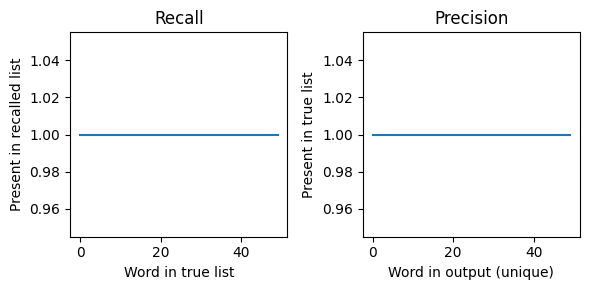

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. You will now see another list of words. letter, whale, message, banner, face, planet, patrol, magnet, globe, pan, jewel, sardine, dice, pike, chick, fort, chicken, wave, bus, sink, emerald, prison, tower, shark, citizen, grasshopper, cabin, university, boulevard, telescope, heater, pad, reptile, cactus, jam, moss, guardian, shoulder, sponge, cyclone, rattle, mustard, pool, family, bison, railroad, apartment, bunny, turkey, lollipop, treat, surgeon, sleeve, acorn, shower, pendulum, herb, ear, utensil, hare, tote, blackberry, creature, rocket, dinner, drum, chip, quilt, net, b

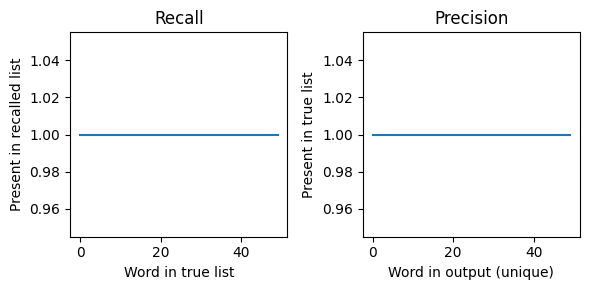

In [151]:
for inp in [simple_inp, interjection_inp]:
    print(inp)
    lst_words = query_model(pipe, inp)
    print(lst_words)
    plot_recall_precision(words, lst_words)

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Please list all words that start with the letters a,b,c,d,e,f,g,h. List these words in any order you'd like without listing any other words provided in the list. Do not think step by step, only output the list of words.
['antler', 'bank', 'bulletin', 'boss', 'button', 'cheddar', 'chimney', 'cheetah (not in list)', 'cheese (not in list)', 'cheddar (already listed)', 'deodorant', 'employee', 'earring', 'enemy', 'earring', 'giraffe', 'goat (not in list)', 'hall', 'house', 'igloo', 'microwave (not in list)', 'onion', 'oatmeal', 'proton', 'quail', 'roach', 'sap', 'senate', 'sugar

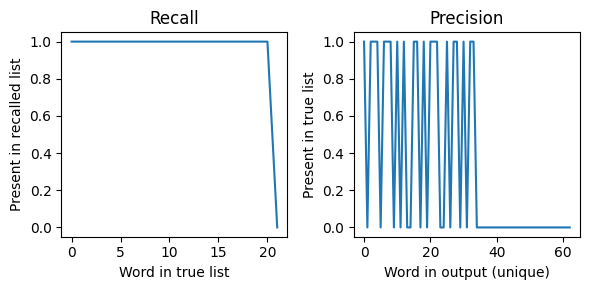

Here is a list of words. After seeing this list, list all the words starting with a,b,c,d,e,f,g,h. Make sure to not reproduce any other words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Please list all words that start with the letters a,b,c,d,e,f,g,h. List these words in any order you'd like without listing any other words provided in the list. Do not think step by step, only output the list of words.
['bank', 'employee', 'chimney', 'cheddar', 'deodorant', 'earring', 'hall', 'oatmeal', 'button', 'whistle', 'bulb', 'scout', 'cub', 'proton', 'bulletin', 'sister', 'house', 'microwave', 'sap', 'antler', 'pearl', 'van', 'fleet', 'roach', 'grocer

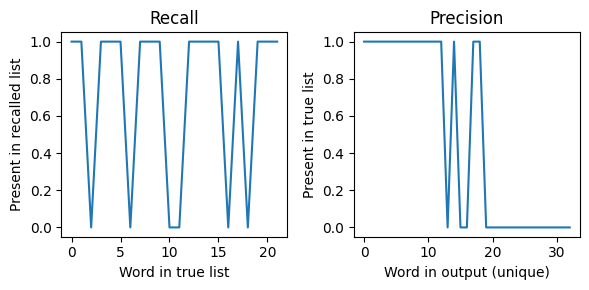

Here is a list of words. After seeing this list, list all the words starting with a,b,c,d,e,f,g,h. Make sure to not reproduce any other words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. You will now see another list of words. Later, when reproducing the first list of words, you should not reproduce these words: letter, whale, message, banner, face, planet, patrol, magnet, globe, pan, jewel, sardine, dice, pike, chick, fort, chicken, wave, bus, sink, emerald, prison, tower, shark, citizen, grasshopper, cabin, university, boulevard, telescope, heater, pad, reptile, cactus, jam, moss, guardian, shoulder, sponge, cyclone, rattle, mustard, pool, 

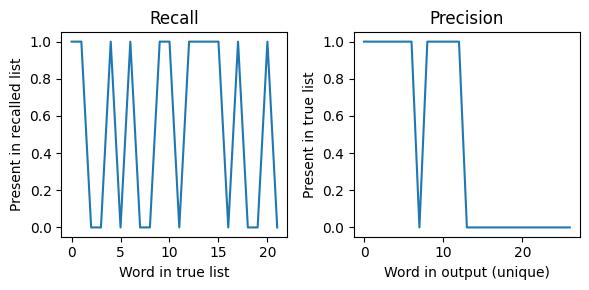

In [152]:
# GATED
for inp in [gated_inp, gated_informed_inp, gated_informed_interjection_inp]:
    print(inp)
    lst_words = query_model(pipe, inp)
    print(lst_words)
    plot_recall_precision(words, lst_words, gated=True)

# 2. List recognition

In [153]:
list_length = 50
interjection_length = 100
include_interjected_in_test = False

In [154]:
import string
from scipy.stats import norm

def query_model_recognition(pipe, inp):
    outputs = query_model_helper(pipe, inp)[0]["generated_text"][-1]['content']
    lst_words = [int(o) for o in outputs if o in ['0','1']]
    return lst_words

# def plot_results(true, resp):
#     true = np.array(true)
#     resp = np.array(resp)
#     hit_rate = np.sum((resp) & (true))/np.sum(true)
#     false_alarm_rate = np.sum((resp) & (true==0))/np.sum(true==0)
#     d_prime = norm.ppf(hit_rate) - norm.ppf(false_alarm_rate)
#     x,y,labels = [1,2,3],[hit_rate, false_alarm_rate, d_prime],['hit rate', 'false alarm rate', 'd\'']

#     if include_interjected_in_test:
#         x.extend([4,5])
#         labels.extend(['false alarm rate on new', 'false alarm rate on interjected'])
#         y.extend([
#             (np.sum((true == 0) & (resp))/np.sum(true==0)),
#             (np.sum((true == 2) & (resp))/np.sum(true==2)),
#         ])

#     plt.figure(figsize=(3,3))
#     plt.suptitle('Recognition test performance')
#     plt.bar(x,y)
#     plt.xticks(x, labels=labels, rotation=30)
#     plt.ylim(0,1)
#     plt.tight_layout()
#     plt.show()

In [155]:
words = subsample_words(all_words, list_length, seed=0)
lures = subsample_words(all_words, list_length, seed=0, avoid=words)
interjection_words = subsample_words(all_words, list_length, seed=0, avoid=words+lures)
if include_interjected_in_test:
    interjection_sample = subsample_words(interjection_words, list_length, seed=0)
    combined = [(w, 1) for w in words] + [(l, 0) for l in lures] + [(l, 2) for l in interjection_sample] # new label 2 for interjection
else:
    combined = [(w, 1) for w in words] + [(l, 0) for l in lures]

np.random.seed(0)
perm = np.random.permutation(len(combined))
test_words = [combined[i][0] for i in perm]
test_labels = [combined[i][1] for i in perm]

In [333]:
recognition_inp = make_inp(
    words,test_words,
    preamble = "Here is a list of words:",
    cue = "Now we'll begin the memory test. Here is another list of words, " \
        "containing some words from the original list and some new words. " \
        "Please output a list of all the words in the test list that were present in the original list. " \
        "Only output the words. Here is the test list: "
)
print(recognition_inp)

recognition_inp_informed = make_inp(
    words,test_words,
    preamble = "Here is a list of words. After seeing this list, you will be tested on your memory for words in this list:",
    cue = "Now we'll begin the memory test. Here is another list of words, containing some words from the original list and some new words. " \
        "Please output a list of all the words in the test list that were present in the original list. " \
        "Only output the words. Here is the test list: "
)
print(recognition_inp_informed)


recognition_inp_interjection = make_inp(
    words,test_words,
    preamble = "Here is a list of words:",
    cue = "Now we'll begin the memory test. Here is another list of words, " \
        "containing some words from the original list, some from the intervening list, and some new words. " \
        "Please output a list of all the words in the test list that were present in the original list. " \
        "Only output the words. Here is the test list: ",
    interjection = "You will now see another list of words:",
    interjection_words = interjection_words,
)
print(recognition_inp_interjection)


recognition_inp_interjection_informed = make_inp(
    words, test_words,
    preamble = "Here is a list of words. After seeing this list, you will see another list, " \
        "and then a memory test for the words in the original (first) list:",
    cue = "Now we'll begin the memory test. Here is another list of words, " \
        "containing some words from the original list, some from the intervening list, and some new words. " \
        "Please output a list of all the words in the test list that were present in the original list. " \
        "Only output the words. Here is the test list: ",
    interjection = "You will now see another list of words. Later, when doing the memory test, " \
        "you should not base your responses on the words in this list:",
    interjection_words = interjection_words,
)
print(recognition_inp_interjection_informed)

Here is a list of words: crutch, virus, belly, wire, stone. Now we'll begin the memory test. Here is another list of words, containing some words from the original list and some new words. Please output a list of all the words in the test list that were present in the original list. Only output the words. Here is the test list: chimney, guardian, man, planet, grasshopper, family, fleet, shark, face, railroad, banner, pool, boulevard, deodorant, list, boss, earring, telephone, oatmeal, whistle, monastery, dice, bank, prison, enemy, antler, ozone, lollipop, reptile, cabin, jewel, heater, rattle, bus, whale, giraffe, van, patrol, pike, citizen, vehicle, sardine, proton, cub, employee, cheddar, cheek, sister, goo, perch, mustard, pan, knuckle, quail, butcher, letter, igloo, button, plumber, message, onion, sugar, chicken, magnet, telescope, moss, hall, jam, pearl, cyclone, bulletin, traitor, bulb, bunny, turkey, sink, senate, bison, tower, university, sap, microphone, pad, biologist, scout

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Now we'll begin the memory test. Here is another list of words, containing some words from the original list and some new words. Please output a list of all the words in the test list that were present in the original list. Only output the words. Here is the test list: chimney, guardian, man, planet, grasshopper, family, fleet, shark, face, railroad, banner, pool, boulevard, deodorant, list, boss, earring, telephone, oatmeal, whistle, monastery, dice, bank, prison, enemy, antler, ozone, lollipop, reptile, cabin, jewel, heater, rattle, bus, whale, giraffe, van, patrol, pike, 

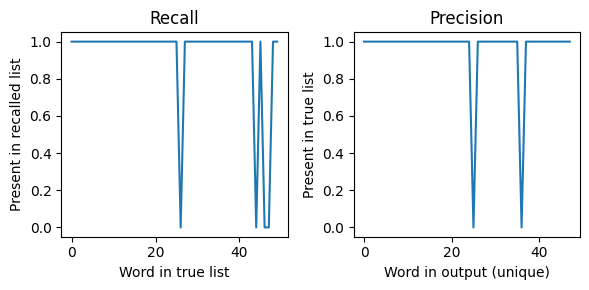

Here is a list of words. After seeing this list, you will be tested on your memory for words in this list: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. Now we'll begin the memory test. Here is another list of words, containing some words from the original list and some new words. Please output a list of all the words in the test list that were present in the original list. Only output the words. Here is the test list: chimney, guardian, man, planet, grasshopper, family, fleet, shark, face, railroad, banner, pool, boulevard, deodorant, list, boss, earring, telephone, oatmeal, whistle, monastery, dice, bank, prison, enemy, antler, ozone, lollipo

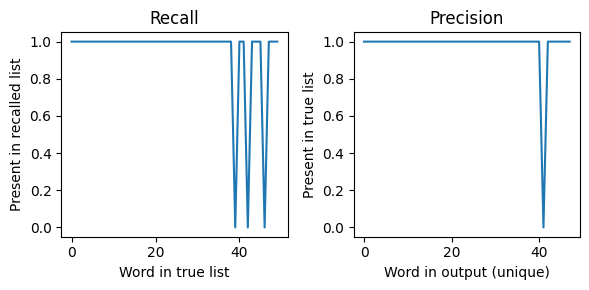

Here is a list of words: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. You will now see another list of words: lock, mosquito, bark, fig, prairie, picture, meal, grill, pen, kitten, sheep, dish, popcorn, church, fugitive, cigar, cab, spine, explosion, ranch, unicorn, skirt, climber, hail, cake, washcloth, boxer, toy, horse, pawn, salesman, camel, ketchup, neutron, harp, society, suburb, deck, root, nursery, pump, fin, blade, rocket, ape, butter, viola, marine, vault, thorn. Now we'll begin the memory test. Here is another list of words, containing some words from the original list, some from the intervening list, and some new words. Please outp

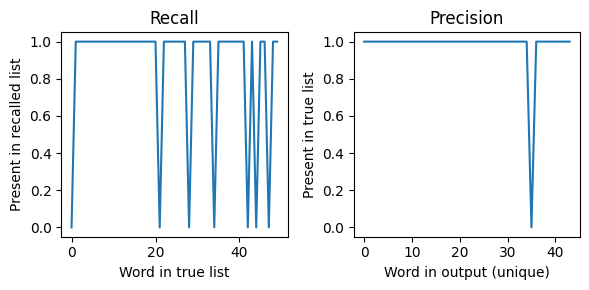

Here is a list of words. After seeing this list, you will see another list, and then a memory test for the words in the original (first) list: knuckle, vehicle, man, bank, employee, perch, ozone, list, whistle, garbage, onion, igloo, roach, deodorant, pearl, cheddar, fleet, cheek, van, bulletin, senate, zucchini, earring, plumber, telephone, sap, chimney, giraffe, butcher, traitor, boss, sugar, hall, oatmeal, quail, button, house, microphone, goo, scout, sister, cub, proton, monastery, pill, enemy, biologist, prince, antler, bulb. You will now see another list of words. Later, when doing the memory test, you should not base your responses on the words in this list: lock, mosquito, bark, fig, prairie, picture, meal, grill, pen, kitten, sheep, dish, popcorn, church, fugitive, cigar, cab, spine, explosion, ranch, unicorn, skirt, climber, hail, cake, washcloth, boxer, toy, horse, pawn, salesman, camel, ketchup, neutron, harp, society, suburb, deck, root, nursery, pump, fin, blade, rocket, 

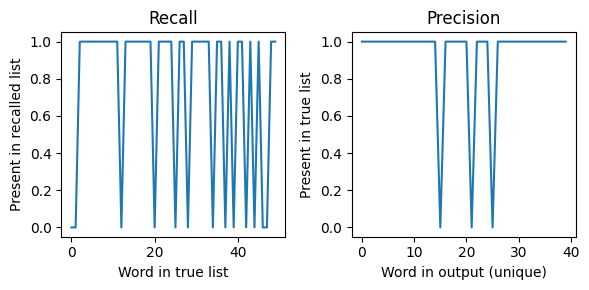

In [157]:
for inp in [recognition_inp, recognition_inp_informed, recognition_inp_interjection, recognition_inp_interjection_informed]:
    print(inp)
    lst_words = query_model(pipe, inp)
    print(lst_words)
    plot_recall_precision(words, lst_words)

# 3. Paired associate learning

In [158]:
list_length = 50
interjection_length = 200

In [200]:
def plot_results(true_list, output_list, interjected_list=[], gated=False):
    ncols = 2

    recall = [w in output_list for w in true_list]
    precision = [w in set(true_list) for w in np.unique(output_list)]
    if gated:
        subset_of_words = [w for w in true_list if w[0] in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]
        recall_gated = [w in output_list for w in subset_of_words]
        precision_gated = [w in set(subset_of_words) for w in np.unique(output_list)]
        ncols +=2

    i_bool = len(interjected_list) >0
    if i_bool:
        precision_int = [w in set(interjected_list) for w in np.unique(output_list)]
        ncols += 1

    fig,ax = plt.subplots(1,ncols,figsize=(ncols*3,3))
    ax[0].plot(recall)
    ax[0].set_title('Recall')
    ax[0].set_xlabel('Word in true list')
    ax[0].set_ylabel('Present in recalled list')

    ax[1].plot(precision)
    ax[1].set_title('Precision')
    ax[1].set_xlabel('Word in output (unique)')
    ax[1].set_ylabel('Present in true list')

    if i_bool:
        ax[2].plot(precision_int)
        ax[2].set_title('False alarms to interjections')
        ax[2].set_xlabel('Word in output (unique)')
        ax[2].set_ylabel('Present in interjection')

    if gated:
        ax[-2].plot(recall_gated)
        ax[-2].set_title('Gated recall')
        ax[-2].set_xlabel('Word in GATED true list (abcdefgh)')
        ax[-2].set_ylabel('Present in recalled list')

        ax[-1].plot(precision_gated)
        ax[-1].set_title('Gated precision')
        ax[-1].set_xlabel('Word in output (unique)')
        ax[-1].set_ylabel('Present in GATED true list (abcdefgh)')
    plt.tight_layout()
    plt.show()

In [161]:
words = subsample_words(all_words, list_length*2, seed=0)
first_words = words[:list_length]
second_words = words[list_length:]
pairs = make_pairs(first_words, second_words)

np.random.seed(0)
perm = np.random.permutation(len(pairs))
shuffled_first_words = [first_words[i] for i in perm]
targets = [second_words[i] for i in perm]

interjection_words = subsample_words(all_words, interjection_length*2, seed=0, avoid=words)
interjection_pairs = make_pairs(interjection_words[:interjection_length], interjection_words[interjection_length:])


In [208]:
pa_inp = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (not the full pairs, just the second words). " \
          "Please only output the list of words, each separated by a comma. Here are the test words: "
)
print(pa_inp)

pa_inp_informed = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs. After seeing this list, you will be tested on your memory for the pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (not the full pairs, just the second words). " \
          "Please only output the list of words, each separated by a comma. Here are the test words: "
)
print(pa_inp_informed)

pa_inp_interjection = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs. After seeing this list, you will be tested on your memory for the pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (not the full pairs, just the second words). " \
          "Please only output the list of words, each separated by a comma. Here are the test words: ",
    interjection = "You will now see another list of word pairs:",
    interjection_words = interjection_pairs,
)

pa_inp_interjection_informed = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then be tested on your memory for these original pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (not the full pairs, just the second words). " \
          "Please only output the list of words, each separated by a comma. Here are the test words: ",
    interjection = "You will now see another list of word pairs. Later, in the memory test, you should not base your responses on the pairs in this list:",
    interjection_words = interjection_pairs,
)

pa_inp_gated = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair in the original list, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (do not output the full pairs, just the second words of the pair), " \
          "but ONLY for words whose pair  starts with a,b,c,d,e,f,g, or h. " \
          "Do not think step-by-step, just output the list of words, each separated by a comma. Here are the test words: "
)
print(pa_inp_gated)

pa_inp_gated_informed = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then " \
        "be tested on your memory ONLY for the pairs where the SECOND word starts with a,b,c,d,e,f,g, and h.",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair in the original list, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (NOT the full pairs, just the second words), " \
          "but ONLY for words whose pair starts with a,b,c,d,e,f,g, or h. " \
          "Do not think step-by-step, just output the list of words, each separated by a comma. Here are the test words: "
)
print(pa_inp_gated_informed)

pa_inp_gated_interjection = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs:",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair in the original list, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (NOT the full pairs, just the second words), " \
          "but ONLY for words whose pair starts with a,b,c,d,e,f,g, or h. " \
          "Do not think step-by-step, just output the list of words, each separated by a comma. Here are the test words: ",
    interjection = "You will now see another list of words:",
    interjection_words = interjection_pairs,

)
print(pa_inp_gated_interjection)

pa_inp_gated_informed_interjection = make_inp(
    pairs, shuffled_first_words,
    preamble = "Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then " \
        "be tested on your memory ONLY for the pairs where the SECOND word starts with a,b,c,d,e,f,g, and h.",
    cue = "Now we'll begin the memory test. Here is a list of words, one from each pair in the original list, in random order. " \
          "Please output the words that each of these words was paired with in the studied list (NOT the full pairs, just the second words), " \
          "but ONLY for words whose pair starts with a,b,c,d,e,f,g, or h. " \
          "Do not think step-by-step, just output the list of words, each separated by a comma. Here are the test words: ",
    interjection = "You will now see another list of words. Later, in the memory test, you should not base your responses on the pairs in this list:",
    interjection_words = interjection_pairs,

)
print(pa_inp_gated_informed_interjection)

Here is a list of word pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. Please output the words that each of these words was paired with in the studied list (not the full pairs, just the second wo

First words:  ['butcher', 'igloo', 'onion', 'cub', 'man', 'giraffe', 'goo', 'sugar', 'earring', 'employee', 'oatmeal', 'button', 'chimney', 'quail', 'van', 'list', 'pearl', 'enemy', 'antler', 'traitor', 'cheddar', 'boss', 'hall', 'fleet', 'proton', 'senate', 'monastery', 'whistle', 'deodorant', 'sap', 'perch', 'cheek', 'sister', 'bulb', 'vehicle', 'roach', 'microphone', 'telephone', 'ozone', 'plumber', 'house', 'zucchini', 'bulletin', 'garbage', 'scout', 'biologist', 'bank', 'knuckle', 'prince', 'pill']
Second words:  ['gallon', 'transplant', 'driveway', 'monster', 'thicket', 'camera', 'president', 'temple', 'bug', 'stallion', 'priest', 'porcupine', 'paint', 'hamper', 'dough', 'screw', 'bird', 'gorilla', 'fort', 'producer', 'cousin', 'fountain', 'castle', 'raisin', 'buggy', 'postage', 'sage', 'paper', 'teapot', 'pen', 'shell', 'detergent', 'foot', 'copier', 'lid', 'guard', 'saturn', 'grasshopper', 'acorn', 'brain', 'crutch', 'moss', 'chemist', 'hand', 'rodent', 'refrigerator', 'widow',

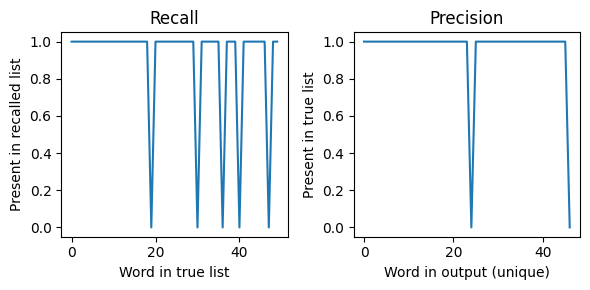

Here is a list of word pairs. After seeing this list, you will be tested on your memory for the pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. Now we'll begin the memory test. Here is a list of words, one from each pair, in random order. Please output the words that each of these words wa

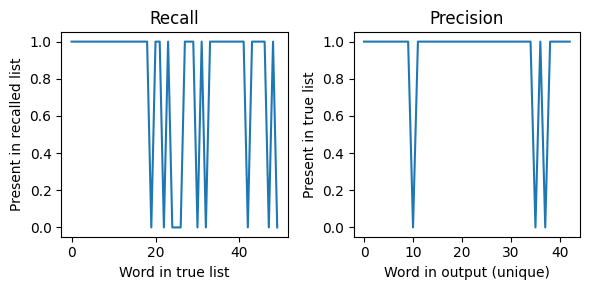

Here is a list of word pairs. After seeing this list, you will be tested on your memory for the pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. You will now see another list of word pairs: lodge-scenery, mop-container, banquet-vegetable, field-berry, potato-coleslaw, pickle-comb, meadow-ja

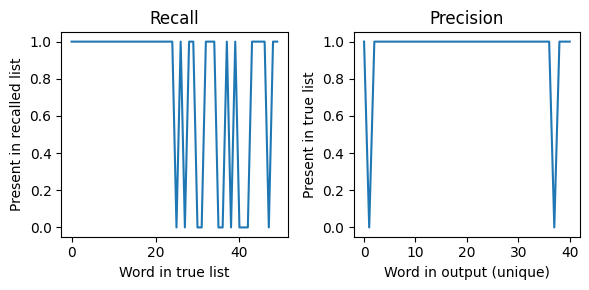

Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then be tested on your memory for these original pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. You will now see another list of word pairs. Later, in the memory test, you should not base your re

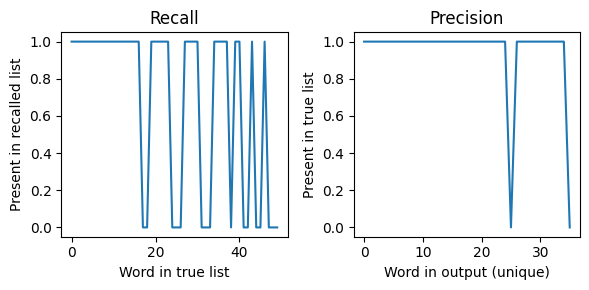

In [198]:
print('First words: ', shuffled_first_words)
print('Second words: ', targets)
for inp in [pa_inp, pa_inp_informed, pa_inp_interjection, pa_inp_interjection_informed]:
    print(inp)
    output = query_model(pipe, inp)
    print(output)
    plot_results(targets, output)

Here is a list of word pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. Now we'll begin the memory test. Here is a list of words, one from each pair in the original list, in random order. Please output the words that each of these words was paired with in the studied list (do not output the

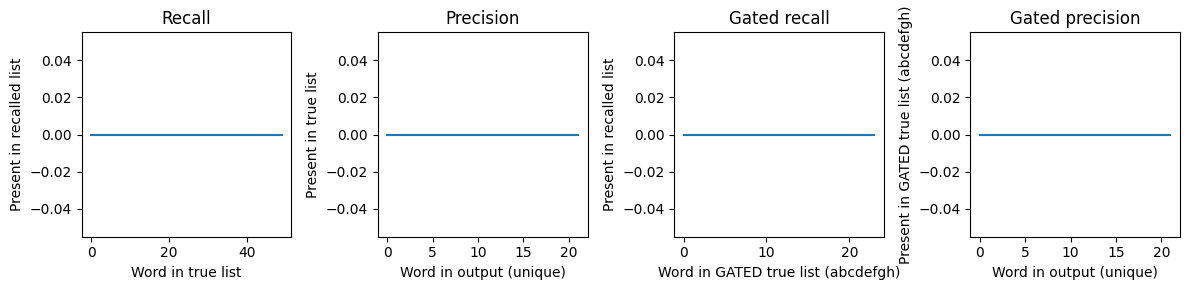

Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then be tested on your memory ONLY for the pairs where the SECOND word starts with a,b,c,d,e,f,g, and h. knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. Now we'll begin the memory test. Here is a list of

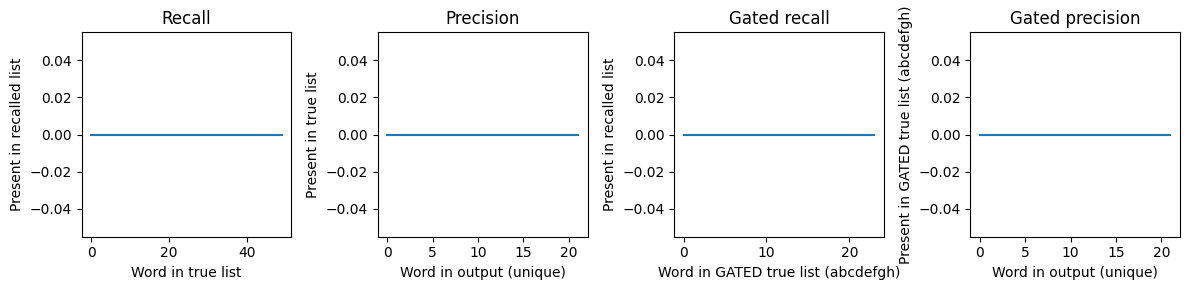

Here is a list of word pairs: knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. You will now see another list of words: lodge-scenery, mop-container, banquet-vegetable, field-berry, potato-coleslaw, pickle-comb, meadow-japan, groceries-radish, pedestrian-witness, kiwi-casket, sheep-silk, disc-nucle

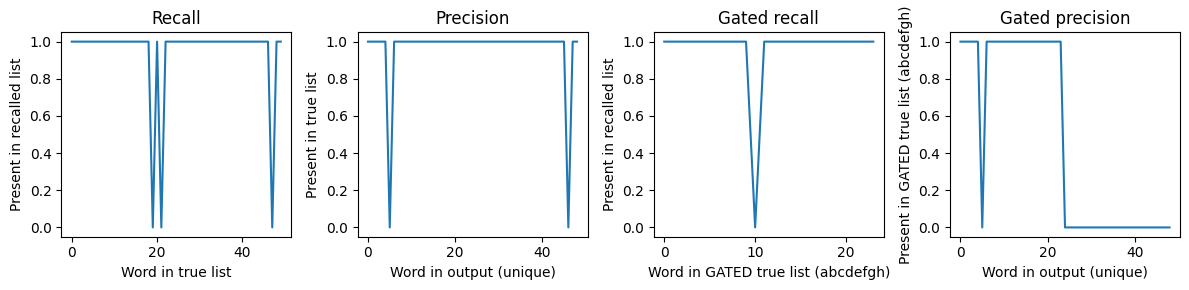

Here is a list of word pairs. After seeing this list, you will see another list of pairs, and then be tested on your memory ONLY for the pairs where the SECOND word starts with a,b,c,d,e,f,g, and h. knuckle-toenail, vehicle-lid, man-thicket, bank-widow, employee-stallion, perch-shell, ozone-acorn, list-screw, whistle-paper, garbage-hand, onion-driveway, igloo-transplant, roach-guard, deodorant-teapot, pearl-bird, cheddar-cousin, fleet-raisin, cheek-detergent, van-dough, bulletin-chemist, senate-postage, zucchini-moss, earring-bug, plumber-brain, telephone-grasshopper, sap-pen, chimney-paint, giraffe-camera, butcher-gallon, traitor-producer, boss-fountain, sugar-temple, hall-castle, oatmeal-priest, quail-hamper, button-porcupine, house-crutch, microphone-saturn, goo-president, scout-rodent, sister-foot, cub-monster, proton-buggy, monastery-sage, pill-zebra, enemy-gorilla, biologist-refrigerator, prince-dresser, antler-fort, bulb-copier. You will now see another list of words. Later, in 

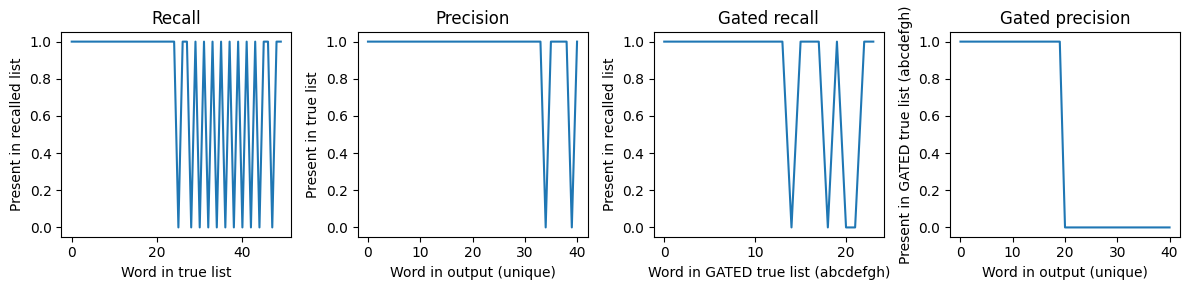

In [209]:
for inp in [pa_inp_gated, pa_inp_gated_informed, pa_inp_gated_interjection, pa_inp_gated_informed_interjection]:
    print(inp)
    output = query_model(pipe, inp)
    print(output)
    plot_results(targets, output, gated=True)

# 4. Paired associate inference

Learn: a-b, b-c

Test: a vs c/d?


In [289]:
list_length = 50
list_length = round(list_length/3)*3 # make into closest multiple of 3
interjection_length = 200

In [290]:
def plot_results(target_words, lure_words, output_words, interjected_list=[]):
    recall = [w in output_words for w in target_words]
    precision = [w in set(target_words) for w in np.unique(output_words)]
    precision_lure = [w in set(lure_words) for w in np.unique(output_words)]
    precision_int = [w in set(interjected_list) for w in np.unique(output_words)]

    ncols = 3 if len(interjected_list) == 0 else 4
    fig,ax = plt.subplots(1,ncols,figsize=(3*ncols,3))
    ax[0].plot(recall)
    ax[0].set_title('Recall')
    ax[0].set_xlabel('Word in true list')
    ax[0].set_ylabel('Present in recalled list')

    ax[1].plot(precision)
    ax[1].set_title('Precision')
    ax[1].set_xlabel('Word in output (unique)')
    ax[1].set_ylabel('Present in TRUE list')

    ax[2].plot(precision_lure)
    ax[2].set_title('Lure precision')
    ax[2].set_xlabel('Word in output (unique)')
    ax[2].set_ylabel('Present in LURE list')

    if len(interjected_list) > 0:
        ax[3].plot(precision_int)
        ax[3].set_title('Interjection precision')
        ax[3].set_xlabel('Word in output (unique)')
        ax[3].set_ylabel('Present in INTERJECTION list')
    plt.tight_layout()
    plt.show()

In [291]:
# trials are either a->b, b->c, or d->e
# 1/3 of trials have d, 1/3 have e, 1/3 a, 1/3 c, 2/3 b
words = subsample_words(all_words, list_length*2, seed=0)
a_words = words[:int(list_length/3)]
b_words = words[int(list_length/3):list_length]
c_words = words[list_length:int(4/3*list_length)]
d_words = words[int(4/3*list_length):int(5/3*list_length)]
e_words = words[int(5/3*list_length):]

ab_pairs = make_pairs(a_words, b_words) # 1/3 of trials
bc_pairs = make_pairs(b_words, c_words) # 1/3 of trials
de_pairs = make_pairs(d_words, e_words) # 1/3 of trials

# need to see the AB pairs before the BC, but the DE can come anywhere
training_pairs = make_training_order(ab_pairs, bc_pairs, de_pairs)
test_probes, targets, lures = make_test_probes(cue_words = a_words, target_words = c_words, lure_words = e_words)

interjection_words = subsample_words(all_words, interjection_length*2, seed=0, avoid=words)
interjection_pairs = make_pairs(interjection_words[:interjection_length], interjection_words[interjection_length:])

In [292]:
pai_inp = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. " \
        "Select a target based on the associations learned in the original list. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
)
print(pai_inp)

pai_inp_informed = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs. " \
        "After seeing this list, you will be tested on inferential associations between words in this list. " \
        "Here are the word pairs:",
    cue = "Now we'll begin the test. Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. " \
        "Select a target based on the associations learned in the original list. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
)
print(pai_inp_informed)

pai_inp_informed_interjected = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs. After seeing this list, you will see another list of pairs. " \
        "Then, you will be tested on inferential associations between words in this original list of pairs. " \
        "Here are the word pairs:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. " \
        "Select a target based on the associations learned in the original list. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
    interjection = "You will now see another list of word pairs. Later, during the test, you should not base your responses on the pairs in this list:",
    interjection_words = interjection_pairs,
)
print(pai_inp_informed_interjected)

Here is a list of word pairs: roach-traitor, paint-sage, grasshopper-monster, pen-buggy, list-telephone, perch-earring, chemist-crutch, vehicle-van, priest-country, brain-foot, knuckle-cheek, employee-zucchini, dough-porcupine, pearl-sugar, hamper-costume, camera-zebra, bug-rodent, igloo-butcher, traitor-teapot, cheek-lid, cheddar-hall, onion-giraffe, zucchini-shell, temple-fort, bank-senate, gallon-gorilla, garbage-chimney, senate-stallion, fountain-dresser, ozone-plumber, postage-saturn, van-thicket, butcher-guard, whistle-sap, producer-refrigerator, deodorant-boss, moss-president, plumber-screw, earring-acorn, boss-bird, sap-hand, giraffe-transplant, sugar-cousin, hall-raisin, fleet-oatmeal, man-bulletin, oatmeal-detergent, chimney-driveway, castle-copier, bulletin-widow, telephone-paper. Now we'll begin the test. Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. Select a target based on the associations learned in the ori

Here is a list of word pairs: roach-traitor, paint-sage, grasshopper-monster, pen-buggy, list-telephone, perch-earring, chemist-crutch, vehicle-van, priest-country, brain-foot, knuckle-cheek, employee-zucchini, dough-porcupine, pearl-sugar, hamper-costume, camera-zebra, bug-rodent, igloo-butcher, traitor-teapot, cheek-lid, cheddar-hall, onion-giraffe, zucchini-shell, temple-fort, bank-senate, gallon-gorilla, garbage-chimney, senate-stallion, fountain-dresser, ozone-plumber, postage-saturn, van-thicket, butcher-guard, whistle-sap, producer-refrigerator, deodorant-boss, moss-president, plumber-screw, earring-acorn, boss-bird, sap-hand, giraffe-transplant, sugar-cousin, hall-raisin, fleet-oatmeal, man-bulletin, oatmeal-detergent, chimney-driveway, castle-copier, bulletin-widow, telephone-paper. Now we'll begin the test. Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. Select a target based on the associations learned in the ori

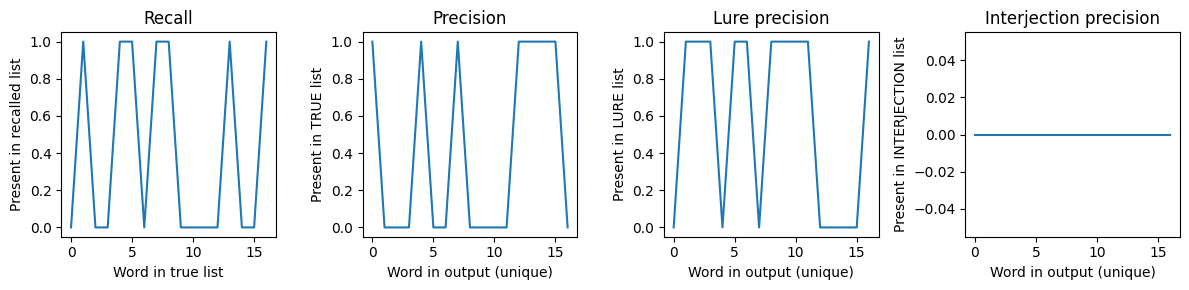

Here is a list of word pairs. After seeing this list, you will be tested on inferential associations between words in this list. Here are the word pairs: roach-traitor, paint-sage, grasshopper-monster, pen-buggy, list-telephone, perch-earring, chemist-crutch, vehicle-van, priest-country, brain-foot, knuckle-cheek, employee-zucchini, dough-porcupine, pearl-sugar, hamper-costume, camera-zebra, bug-rodent, igloo-butcher, traitor-teapot, cheek-lid, cheddar-hall, onion-giraffe, zucchini-shell, temple-fort, bank-senate, gallon-gorilla, garbage-chimney, senate-stallion, fountain-dresser, ozone-plumber, postage-saturn, van-thicket, butcher-guard, whistle-sap, producer-refrigerator, deodorant-boss, moss-president, plumber-screw, earring-acorn, boss-bird, sap-hand, giraffe-transplant, sugar-cousin, hall-raisin, fleet-oatmeal, man-bulletin, oatmeal-detergent, chimney-driveway, castle-copier, bulletin-widow, telephone-paper. Now we'll begin the test. Here is a list of test probes; each one contain

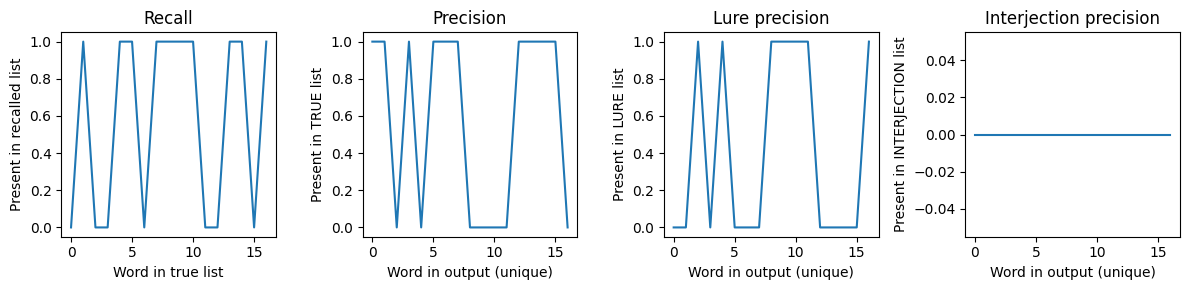

Here is a list of word pairs. After seeing this list, you will see another list of pairs. Then, you will be tested on inferential associations between words in this original list of pairs. Here are the word pairs: roach-traitor, paint-sage, grasshopper-monster, pen-buggy, list-telephone, perch-earring, chemist-crutch, vehicle-van, priest-country, brain-foot, knuckle-cheek, employee-zucchini, dough-porcupine, pearl-sugar, hamper-costume, camera-zebra, bug-rodent, igloo-butcher, traitor-teapot, cheek-lid, cheddar-hall, onion-giraffe, zucchini-shell, temple-fort, bank-senate, gallon-gorilla, garbage-chimney, senate-stallion, fountain-dresser, ozone-plumber, postage-saturn, van-thicket, butcher-guard, whistle-sap, producer-refrigerator, deodorant-boss, moss-president, plumber-screw, earring-acorn, boss-bird, sap-hand, giraffe-transplant, sugar-cousin, hall-raisin, fleet-oatmeal, man-bulletin, oatmeal-detergent, chimney-driveway, castle-copier, bulletin-widow, telephone-paper. You will now 

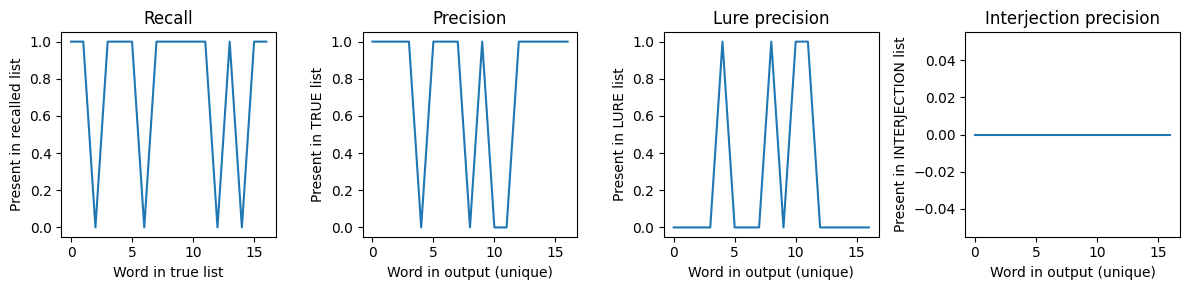

In [293]:
for inp in [pai_inp, pai_inp_informed, pai_inp_informed_interjected]:
    print(inp)
    output = query_model(pipe, inp)
    print(output)
    plot_results(targets, lures, output, interjection_words) # C are targets, E are lures

# 5. Acquired equivalence


a -> b

c -> b

a -> d

c -> ? d or e

In [294]:
list_length = 50
list_length = round(list_length/4)*4 # make into closest multiple of 4
interjection_length = 200

In [295]:
def plot_results(target_words, lure_words, output_words, interjected_list=[]):
    recall = [w in output_words for w in target_words]
    precision = [w in set(target_words) for w in np.unique(output_words)]
    precision_lure = [w in set(lure_words) for w in np.unique(output_words)]
    precision_int = [w in set(interjected_list) for w in np.unique(output_words)]

    ncols = 3 if len(interjected_list) == 0 else 4
    fig,ax = plt.subplots(1,ncols, figsize=(ncols*3,3))
    ax[0].plot(recall)
    ax[0].set_title('Recall')
    ax[0].set_xlabel('Word in true list')
    ax[0].set_ylabel('Present in recalled list')

    ax[1].plot(precision)
    ax[1].set_title('Precision')
    ax[1].set_xlabel('Word in output (unique)')
    ax[1].set_ylabel('Present in TRUE list')

    ax[2].plot(precision_lure)
    ax[2].set_title('Lure precision')
    ax[2].set_xlabel('Word in output (unique)')
    ax[2].set_ylabel('Present in LURE list')

    if len(interjected_list) > 0:
        ax[3].plot(precision_int)
        ax[3].set_title('Interjection precision')
        ax[3].set_xlabel('Word in output (unique)')
        ax[3].set_ylabel('Present in INTERJECTION list')
    plt.tight_layout()
    plt.show()


In [296]:
words = subsample_words(all_words, list_length*3)
a_words = words[:int(list_length/2)]
c_words = words[int(list_length/2):list_length]
b_words = words[list_length:int(list_length*2)] # all will have a b-word
d_words = words[int(list_length*2):]

ab_pairs = make_pairs(a_words, b_words) # 1/3 of trials
cb_pairs = make_pairs(c_words,b_words) # 1/3 of trials

training_pairs = make_training_order(ab_pairs, cb_pairs)
ad_pairs = make_pairs(a_words, d_words)
training_pairs = training_pairs + ad_pairs

d_shuffled_lures = generate_derangement(d_words)
test_probes, targets, lures = make_test_probes(cue_words = a_words, target_words = c_words, lure_words = d_shuffled_lures)

interjection_words = subsample_words(all_words, interjection_length*2, seed=0, avoid=words)
interjection_pairs = make_pairs(interjection_words[:interjection_length], interjection_words[interjection_length:])

In [297]:
ae_inp = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one contains a CUE word, and two possible TARGETS. " \
        "Select a target based on the associations you've learned in the original list. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
)
print(ae_inp)

ae_inp_informed = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs. " \
        "After seeing this list, you will be tested on inferential associations between words in this list. " \
        "Here are the word pairs:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. " \
        "Select a target based on the associations you've learned. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
)
print(ae_inp_informed)

ae_inp_informed_interjected = make_inp(
    training_pairs, test_probes,
    preamble = "Here is a list of word pairs. " \
        "After seeing this list, you will see another list of pairs. " \
        "Then, you will be tested on inferential associations between words in this list. " \
        "Here are the word pairs:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one contains a CUE word, from the original list, and two possible TARGETS. " \
        "Select a target based on the associations you've learned. " \
        "Please output a list of your chosen targets (one of the two target words, for each cue in the list); do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test words:",
    interjection = "You will now see another list of word pairs. Later, during the test, you should not base your responses on the pairs in this list:",
    interjection_words = interjection_pairs,
)
print(ae_inp_informed_interjected)

Here is a list of word pairs: robe-street, winner-silverware, pit-elm, store-clay, coward-telescope, coffin-ancestor, jelly-sibling, paddle-elm, litter-clay, marble-pasta, washer-department, mouse-sardine, incense-twister, robin-scientist, chipmunk-sardine, stream-parrot, engine-possum, delinquent-grill, library-parrot, kid-twister, cupboard-pasta, neck-telescope, bison-grease, chime-department, predator-grease, brick-pastry, shed-scientist, taxi-ball, cinnamon-ball, cactus-ancestor, designer-star, mechanic-heart, crew-heart, university-whistle, skate-pastry, attire-piston, cardinal-street, bark-sibling, youth-star, cap-gown, ticket-pill, racket-whistle, elk-grill, passage-pill, deck-possum, crow-silverware, sage-piston, instructor-gown, winner-knapsack, robe-plate, ticket-paw, stream-bag, delinquent-record, marble-buffalo, brick-straw, jelly-writer, designer-picture, engine-vehicle, robin-sand, washer-bouquet, coffin-marsh, mechanic-valve, coward-cuff, incense-fork, cap-pole, bison-sa

Here is a list of word pairs: robe-street, winner-silverware, pit-elm, store-clay, coward-telescope, coffin-ancestor, jelly-sibling, paddle-elm, litter-clay, marble-pasta, washer-department, mouse-sardine, incense-twister, robin-scientist, chipmunk-sardine, stream-parrot, engine-possum, delinquent-grill, library-parrot, kid-twister, cupboard-pasta, neck-telescope, bison-grease, chime-department, predator-grease, brick-pastry, shed-scientist, taxi-ball, cinnamon-ball, cactus-ancestor, designer-star, mechanic-heart, crew-heart, university-whistle, skate-pastry, attire-piston, cardinal-street, bark-sibling, youth-star, cap-gown, ticket-pill, racket-whistle, elk-grill, passage-pill, deck-possum, crow-silverware, sage-piston, instructor-gown, winner-knapsack, robe-plate, ticket-paw, stream-bag, delinquent-record, marble-buffalo, brick-straw, jelly-writer, designer-picture, engine-vehicle, robin-sand, washer-bouquet, coffin-marsh, mechanic-valve, coward-cuff, incense-fork, cap-pole, bison-sa

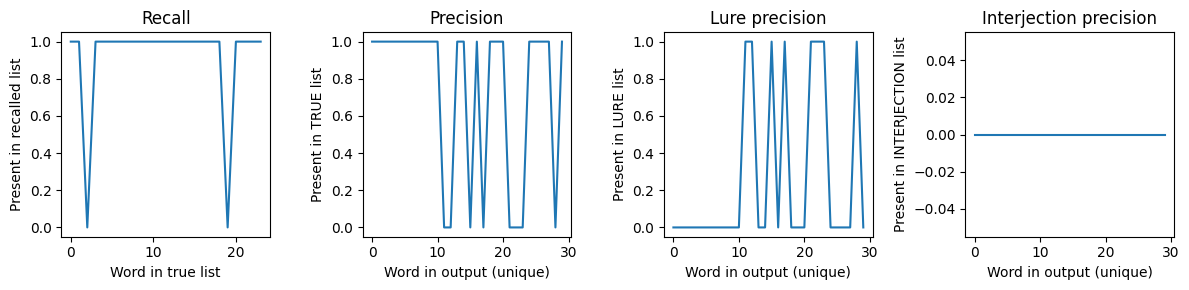

Here is a list of word pairs. After seeing this list, you will be tested on inferential associations between words in this list. Here are the word pairs: robe-street, winner-silverware, pit-elm, store-clay, coward-telescope, coffin-ancestor, jelly-sibling, paddle-elm, litter-clay, marble-pasta, washer-department, mouse-sardine, incense-twister, robin-scientist, chipmunk-sardine, stream-parrot, engine-possum, delinquent-grill, library-parrot, kid-twister, cupboard-pasta, neck-telescope, bison-grease, chime-department, predator-grease, brick-pastry, shed-scientist, taxi-ball, cinnamon-ball, cactus-ancestor, designer-star, mechanic-heart, crew-heart, university-whistle, skate-pastry, attire-piston, cardinal-street, bark-sibling, youth-star, cap-gown, ticket-pill, racket-whistle, elk-grill, passage-pill, deck-possum, crow-silverware, sage-piston, instructor-gown, winner-knapsack, robe-plate, ticket-paw, stream-bag, delinquent-record, marble-buffalo, brick-straw, jelly-writer, designer-pict

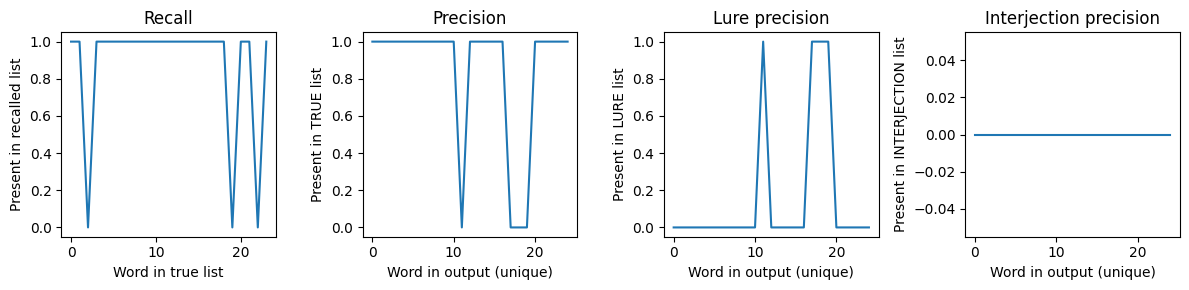

Here is a list of word pairs. After seeing this list, you will see another list of pairs. Then, you will be tested on inferential associations between words in this list. Here are the word pairs: robe-street, winner-silverware, pit-elm, store-clay, coward-telescope, coffin-ancestor, jelly-sibling, paddle-elm, litter-clay, marble-pasta, washer-department, mouse-sardine, incense-twister, robin-scientist, chipmunk-sardine, stream-parrot, engine-possum, delinquent-grill, library-parrot, kid-twister, cupboard-pasta, neck-telescope, bison-grease, chime-department, predator-grease, brick-pastry, shed-scientist, taxi-ball, cinnamon-ball, cactus-ancestor, designer-star, mechanic-heart, crew-heart, university-whistle, skate-pastry, attire-piston, cardinal-street, bark-sibling, youth-star, cap-gown, ticket-pill, racket-whistle, elk-grill, passage-pill, deck-possum, crow-silverware, sage-piston, instructor-gown, winner-knapsack, robe-plate, ticket-paw, stream-bag, delinquent-record, marble-buffalo

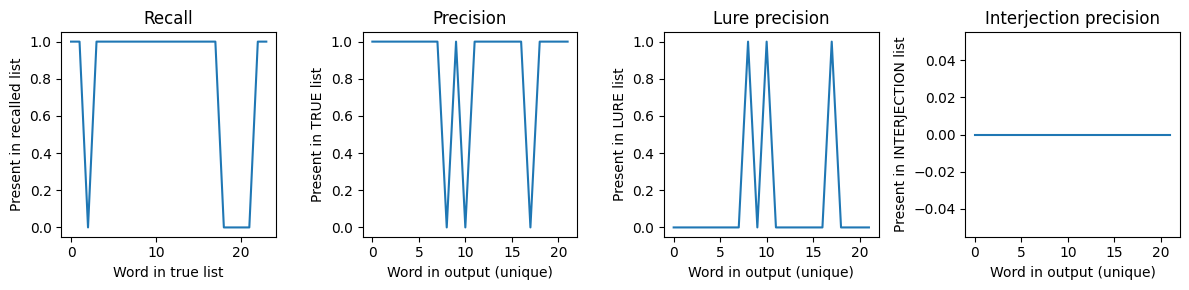

In [298]:
for inp in [ae_inp, ae_inp_informed, ae_inp_informed_interjected]:
    print(inp)
    output = query_model(pipe, inp)
    print(output)
    plot_results(targets, lures, output, interjection_words) # C are targets, E are lures

# 6. Transitive inference

In [340]:
transitive_chain_length = 5 # A > B > C > D > E ...
interjection_length = 100

In [336]:
def make_transitive_inference_probes(words):
    np.random.seed(0)
    bigger, smaller, distances = [],[], []
    count = 0
    for i in range(transitive_chain_length):
        for j in range(i + 2, transitive_chain_length):  # skip adjacent pairs
            bigger.append(words[i])
            smaller.append(words[j])
            distances.append(j-i)
            count += 1
    perm = np.random.permutation(count)
    bigger = [bigger[p] for p in perm]
    smaller = [smaller[p] for p in perm]
    distances = [distances[p] for p in perm]
    test_probes = make_pairs(bigger, smaller, joiner = "?", randomize=True) # B ? E
    return test_probes, bigger, smaller, distances


def plot_results(bigger, smaller, output, distance=[]):
    bigger = np.array(bigger)
    smaller = np.array(smaller)
    output = np.array(output)

    correct = np.mean([output[i] == bigger[i] for i in range(len(output))])
    incorrect = np.mean([output[i] == smaller[i] for i in range(len(output))])
    other = np.mean([output[i] != bigger[i] and output[i] != smaller[i]  for i in range(len(output))])

    n_cols=1
    if len(distance) > 0:
        n_cols=2
        dist_x,dist_y=[],[]
        for dist in sorted(np.unique(distance)):
            dist_mask = np.array(distance) == dist
            dist_correct = np.mean([output[dist_mask][i] == bigger[dist_mask][i] for i in range(sum(dist_mask))])
            dist_x.append(dist)
            dist_y.append(dist_correct)

    fig,ax = plt.subplots(1,n_cols,figsize=(n_cols*3,3))
    ax = np.atleast_1d(ax)  # ensures ax is always indexable
    ax[0].bar([1,2,3], [correct,incorrect,other])
    ax[0].set_xticks([1,2,3], labels=['Correct','Incorrect','Other response'], rotation=30)
    ax[0].set_ylabel('%')
    ax[0].set_ylim(0,1)

    if len(distance) > 0:
        ax[1].plot(dist_x,dist_y)
        ax[1].set_xlabel('Distance in transitive chain')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_ylim(0,1)
    plt.tight_layout()
    plt.show()

In [341]:
words = subsample_words(all_words, transitive_chain_length) # each stimulus is one word in the chain

adjacent_pairs = make_pairs(words[:-1], words[1:], joiner = '>') # pair up in chain
random.seed(0)
random.shuffle(adjacent_pairs)

test_probes, bigger, smaller, distances = make_transitive_inference_probes(words) # query on pairs of words at least 1 link away

interjection_words = subsample_words(all_words, interjection_length*2, avoid=words)
interjection_pairs = make_pairs(interjection_words[:interjection_length],
                                interjection_words[interjection_length:],
                                joiner = '>')

In [344]:
ti_inp = make_inp(
    adjacent_pairs, test_probes,
    preamble = "Here is a list of relations between words:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one has two target words from the original set with a ? in between. " \
        "Your task is to select the bigger word (>). " \
        "Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test probes:",
)
print(ti_inp)

ti_inp_informed = make_inp(
    adjacent_pairs, test_probes,
    preamble = "Here is a list of relations between words. " \
        "After seeing this list, you will be tested on inferential relations between words in this original set. " \
        "Here are the word relations:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one has two target words from the original set with a ? in between. " \
        "Your task is to select the bigger word (>). " \
        "Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test probes:",
)
print(ti_inp_informed)

ti_inp_informed_interjected = make_inp(
    adjacent_pairs, test_probes,
    preamble = "Here is a list of relations between words. " \
        "After seeing this list, you will see another list of relations. " \
        "Then, you will be tested on inferential relations between words in this original set. " \
        "Here are the word relations:",
    cue = "Now we'll begin the test. " \
        "Here is a list of test probes; each one has two target words from the original set with a ? in between. " \
         "Your task is to select the bigger word (>). " \
        "Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. " \
        "Do not think step by step, only output the list of chosen targets. Here are the test probes:",
    interjection = "You will now see another list of word relations. Later, during the test, you should not base your responses on the relations or words in this list:",
    interjection_words = interjection_pairs,
)
print(ti_inp_informed_interjected)

Here is a list of relations between words: earring>car, helmet>plaster, plaster>earring, car>sailor. Now we'll begin the test. Here is a list of test probes; each one has two target words from the original set with a ? in between. Your task is to select the bigger word (>). Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. Do not think step by step, only output the list of chosen targets. Here are the test probes:earring?sailor, helmet?sailor, helmet?car, plaster?car, earring?helmet, plaster?sailor
Here is a list of relations between words. After seeing this list, you will be tested on inferential relations between words in this original set. Here are the word relations: earring>car, helmet>plaster, plaster>earring, car>sailor. Now we'll begin the test. Here is a list of test probes; each one has two target words from the original set with a ? in between. Your task is to select

Here is a list of relations between words: earring>car, helmet>plaster, plaster>earring, car>sailor. Now we'll begin the test. Here is a list of test probes; each one has two target words from the original set with a ? in between. Your task is to select the bigger word (>). Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. Do not think step by step, only output the list of chosen targets. Here are the test probes:earring?sailor, helmet?sailor, helmet?car, plaster?car, earring?helmet, plaster?sailor
['car', 'sailor', 'car', 'plaster', 'earring', 'plaster']


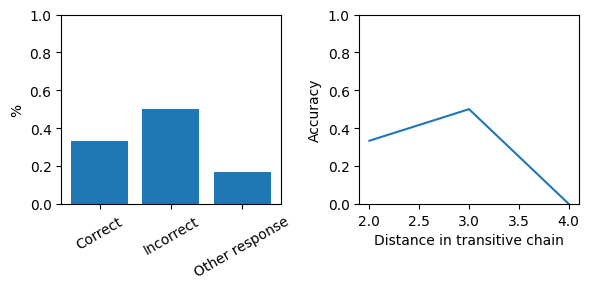

Here is a list of relations between words. After seeing this list, you will be tested on inferential relations between words in this original set. Here are the word relations: earring>car, helmet>plaster, plaster>earring, car>sailor. Now we'll begin the test. Here is a list of test probes; each one has two target words from the original set with a ? in between. Your task is to select the bigger word (>). Please output a list of your chosen bigger targets (one for each in the list of probes!). Do not respond with any word that is not one of the possible targets. Do not think step by step, only output the list of chosen targets. Here are the test probes:earring?sailor, helmet?sailor, helmet?car, plaster?car, earring?helmet, plaster?sailor
['car', 'sailor', 'car', 'plaster', 'earring', 'plaster']


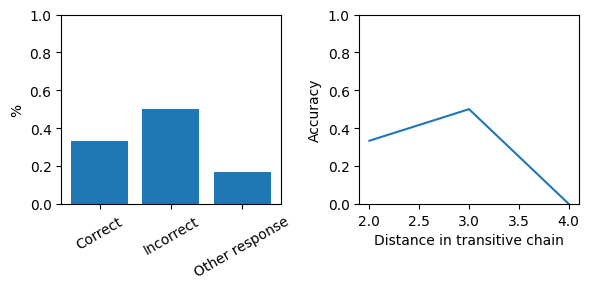

Here is a list of relations between words. After seeing this list, you will see another list of relations. Then, you will be tested on inferential relations between words in this original set. Here are the word relations: earring>car, helmet>plaster, plaster>earring, car>sailor. You will now see another list of word relations. Later, during the test, you should not base your responses on the relations or words in this list: encyclopedia>engine, permit>operator, padding>blueprint, liver>bucket, window>stump, garlic>venus, orange>cello, infant>cigar, robin>bandanna, department>taxi, pedal>possum, cheek>summit, flipper>lawn, cheerleader>pitchfork, vehicle>finger, bulletin>pin, server>donkey, editor>daughter, poet>sty, terminal>rose, sausage>man, chimpanzee>rifle, glacier>fin, butcher>mouth, treasure>parcel, boss>spouse, sun>skirt, hamburger>teacher, ocean>yard, quilt>incense, button>brandy, husband>guard, mildew>cape, gorilla>paddle, scroll>roommate, skillet>shower, cube>harp, publication

IndexError: boolean index did not match indexed array along axis 0; size of axis is 5 but size of corresponding boolean axis is 6

In [345]:
for inp in [ti_inp, ti_inp_informed, ti_inp_informed_interjected]:
    print(inp)
    output = query_model(pipe, inp)
    print(output)
    plot_results(bigger, smaller, output, distances) # C are targets, E are lures